In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
ds = pd.read_csv("C:/Users/aksab/Downloads/Final_Score.csv")

In [4]:
df =ds

In [5]:
# STEP 1: Log transformation for Revenue_change (to handle skewed data)
df['Log_Revenue_change'] = np.log(df['Revenue_change'] + 1)

Z:\Python\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
# STEP 2: Calculate the scaled Closed_dt_change by dividing by Time_to_close
# Ensure Time_to_close > 0 to avoid division by zero
df['Scaled_Closed_dt_change'] = df.apply(
    lambda row: row['Closed_dt_change'] / row['Time_to_close'] if row['Time_to_close'] > 0 else 0,
    axis=1
)

In [7]:
# STEP 3: Z-score normalization
def calculate_z_score(column):
    """Calculate z-scores for a given column."""
    return (column - column.mean()) / column.std()

# Apply z-score normalization for scaled Closed_dt_change and Log_Revenue_change
df['Z_Scaled_Closed_dt_change'] = calculate_z_score(df['Scaled_Closed_dt_change'])
df['Z_Log_Revenue_change'] = calculate_z_score(df['Log_Revenue_change'])


In [8]:
# STEP 4: Adjust for negative Closed_dt_change with penalty
penalty_factor = 1.5
df['Adjusted_Z_Scaled_Closed_dt_change'] = df['Z_Scaled_Closed_dt_change'].apply(
    lambda x: x * penalty_factor if x < 0 else x
)

In [9]:
# STEP 5: Weighted sum of factors (excluding Time_to_close)
weights = {
    'Adjusted_Z_Scaled_Closed_dt_change': 1,  # Adjusted weight for scaled Closed_dt_change
    'Z_Log_Revenue_change': 1,               # Weight for revenue change
}

# Compute weighted volatility score
df['Weighted_Volatility'] = (
    weights['Adjusted_Z_Scaled_Closed_dt_change'] * df['Adjusted_Z_Scaled_Closed_dt_change'] +
    weights['Z_Log_Revenue_change'] * df['Z_Log_Revenue_change']
)


In [10]:
# STEP 6: Historical volatility using rolling standard deviation
rolling_window = 4  # Define the rolling window size (in weeks)
df['Rolling_Std_Scaled_Closed_dt_change'] = df.groupby('Deal_id')['Z_Scaled_Closed_dt_change'].rolling(rolling_window).std().reset_index(0, drop=True)
df['Rolling_Std_Log_Revenue_change'] = df.groupby('Deal_id')['Z_Log_Revenue_change'].rolling(rolling_window).std().reset_index(0, drop=True)

# Replace NaN values from rolling calculations with 0 (for early weeks)
df.fillna(0, inplace=True)

# Combine rolling standard deviations into a historical volatility score
df['Historical_Volatility'] = (
    df['Rolling_Std_Scaled_Closed_dt_change'] +
    df['Rolling_Std_Log_Revenue_change']
)

In [11]:
# STEP 7: Final Volatility Score
df['Final_Volatility_Score'] = df['Weighted_Volatility'] + df['Historical_Volatility']

# STEP 8: Handle first entries for each Deal_id
# Set the volatility score to 0 for the first entry of each Deal_id
df['Is_First_Entry'] = df.groupby('Deal_id').cumcount() == 0
df.loc[df['Is_First_Entry'], 'Final_Volatility_Score'] = 0

In [ ]:
# Drop intermediate columns if not needed
intermediate_columns = [
    'Log_Revenue_change', 'Scaled_Closed_dt_change', 'Z_Scaled_Closed_dt_change',
    'Z_Log_Revenue_change', 'Adjusted_Z_Scaled_Closed_dt_change', 
    'Rolling_Std_Scaled_Closed_dt_change', 'Rolling_Std_Log_Revenue_change', 'Is_First_Entry'
]


In [ ]:
df_final = df.drop(columns=intermediate_columns)

In [12]:
df

,Session_week_no,Deal_id,All_product_codes,Closed_dt_week,Total_weighted_revenue,Time_to_close,Closed_dt_change,Revenue_change,Log_Revenue_change,Scaled_Closed_dt_change,Z_Scaled_Closed_dt_change,Z_Log_Revenue_change,Adjusted_Z_Scaled_Closed_dt_change,Weighted_Volatility,Rolling_Std_Scaled_Closed_dt_change,Rolling_Std_Log_Revenue_change,Historical_Volatility,Final_Volatility_Score,Is_First_Entry
0,23,27270407,12.0,26.0,0.000000,3.0,0.0,0.0,0.0,0.000000,-0.141097,-0.054701,-0.211645,-0.266346,0.000000,0.0,0.000000,0.000000,True
1,12,27A05685,3.0,15.0,0.044035,3.0,0.0,0.0,0.0,0.000000,-0.141097,-0.054701,-0.211645,-0.266346,0.000000,0.0,0.000000,0.000000,True
2,14,4657C97,"12.0, 3.0",39.0,0.131576,25.0,0.0,0.0,0.0,0.000000,-0.141097,-0.054701,-0.211645,-0.266346,0.000000,0.0,0.000000,0.000000,True
3,15,4657C97,"12.0, 3.0",39.0,0.131576,24.0,0.0,0.0,0.0,0.000000,-0.141097,-0.054701,-0.211645,-0.266346,0.000000,0.0,0.000000,-0.266346,False
4,16,4657C97,"12.0, 3.0",39.0,0.131576,23.0,0.0,0.0,0.0,0.000000,-0.141097,-0.054701,-0.211645,-0.266346,0.000000,0.0,0.000000,-0.266346,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779482,27,BCCCC689,11.0,39.0,0.609147,12.0,1.0,0.0,0.0,0.083333,0.070102,-0.054701,0.070102,0.015401,0.105599,0.0,0.105599,0.121001,False
1779483,28,BCCCC689,11.0,39.0,0.609147,11.0,0.0,0.0,0.0,0.000000,-0.141097,-0.054701,-0.211645,-0.266346,0.105599,0.0,0.105599,-0.160746,False
1779484,29,BCCCC689,11.0,39.0,0.609147,10.0,0.0,0.0,0.0,0.000000,-0.141097,-0.054701,-0.211645,-0.266346,0.105599,0.0,0.105599,-0.160746,False
1779485,30,BCCCC689,11.0,39.0,0.609147,9.0,0.0,0.0,0.0,0.000000,-0.141097,-0.054701,-0.211645,-0.266346,0.105599,0.0,0.105599,-0.160746,False


In [21]:
def plot_weekly_averages(data):
    """
    Plot week-on-week averages for predefined factors with a single dataset argument.

    Args:
        data (pd.DataFrame): The dataset containing the factors and session column.
    """
    # Define the session week column and factors with their plotting styles
    session_column = 'Session_week_no'
    factors = {
        'Closed_dt_change': {'marker': 'o', 'color': 'orange', 'label': 'Average Closed Date Change'},
        'Revenue_change': {'marker': 's', 'color': 'green', 'label': 'Average Revenue Change'},
        'Time_to_close': {'marker': '^', 'color': 'blue', 'label': 'Average Time to Close'},
        'Final_Volatility_Score': {'marker': '^', 'color': 'red', 'label': 'Average Volatility Score'}
    }

    # Calculate week-on-week averages for the factors
    average_factors = data.groupby(session_column)[list(factors.keys())].mean().reset_index()

    # Plot each factor
    plt.figure(figsize=(14, 8))
    for factor, style in factors.items():
        plt.plot(
            average_factors[session_column],
            average_factors[factor],
            marker=style.get('marker', 'o'),
            color=style.get('color', 'black'),
            label=style.get('label', factor),
            linewidth=2
        )

    # Add labels, title, legend, and grid
    plt.xlabel('Session Week Number', fontsize=14)
    plt.ylabel('Average Value', fontsize=14)
    plt.title('Week-on-Week Average of Factors and Volatility Score', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Display the plot
    plt.show()


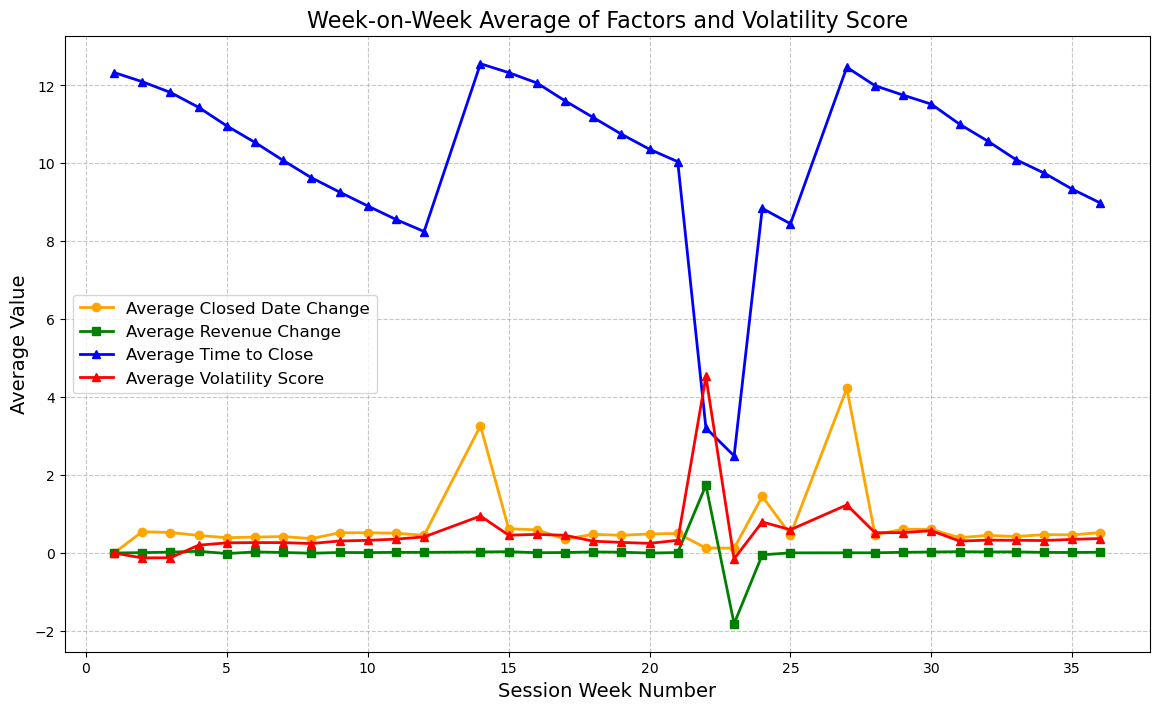

In [22]:
plot_weekly_averages(df)

# Insights Using Descriptive Analytics

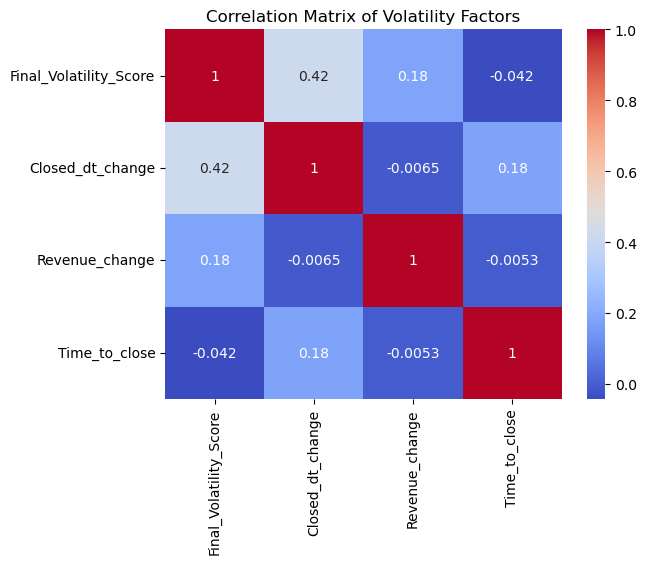

Z:\Python\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
Z:\Python\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


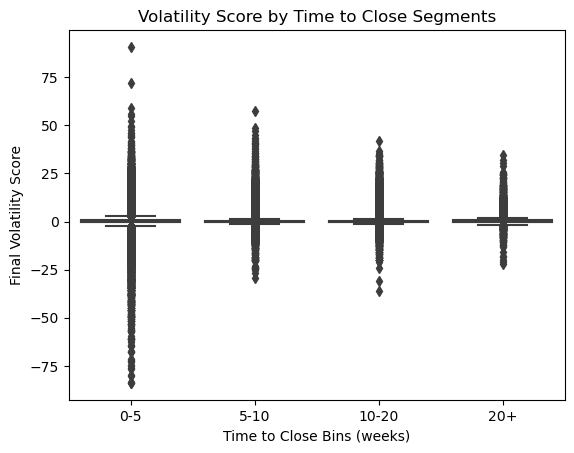

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
correlation = df[['Final_Volatility_Score', 'Closed_dt_change', 'Revenue_change', 'Time_to_close']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Volatility Factors")
plt.show()

# Segment analysis (e.g., by Time_to_close bins)
df['Time_to_close_bin'] = pd.cut(df['Time_to_close'], bins=[0, 5, 10, 20, 50], labels=['0-5', '5-10', '10-20', '20+'])
sns.boxplot(data=df, x='Time_to_close_bin', y='Final_Volatility_Score')
plt.title("Volatility Score by Time to Close Segments")
plt.xlabel("Time to Close Bins (weeks)")
plt.ylabel("Final Volatility Score")
plt.show()


# Actionable Recommendations

In [29]:
# Flag high-volatility deals
high_volatility_threshold = df['Final_Volatility_Score'].quantile(0.25)
hd = df['Final_Volatility_Score'] > high_volatility_threshold

# Recommend action for high-volatility, high-revenue deals
high_priority_deals = df[(df['High_Volatility_Deal']) & (df['Revenue_change'] > 10000)]
print("High-priority deals for intervention:")
print(high_priority_deals[['Deal_id', 'Time_to_close', 'Final_Volatility_Score', 'Revenue_change']])


High-priority deals for intervention:
Empty DataFrame
Columns: [Deal_id, Time_to_close, Final_Volatility_Score, Revenue_change]
Index: []


In [30]:
high_volatility_threshold

-0.2663457849161222

In [32]:
hd.sum()

887899

In [37]:
fdf = df

In [35]:
booked_deals = pd.read_csv("C:/Users/aksab/Downloads/FY25BookedDeals (1).csv")

In [38]:
# Add a flag to indicate booked deals
booked_deals['Is_Booked'] = 1  # 1 = Booked

# Merge with the main dataset
fdf = fdf.merge(booked_deals[['Deal Id', 'Is_Booked']], how='left', left_on='Deal_id', right_on='Deal Id')

# Fill NaN values in the Is_Booked column (deals not in booked dataset)
fdf['Is_Booked'] = fdf['Is_Booked'].fillna(0).astype(int)  # 0 = Not Booked

# Drop the redundant Deal Id column from booked deals dataset
fdf = fdf.drop(columns=['Deal Id'])


In [40]:
# Calculate average volatility metrics for booked vs. unbooked deals
volatility_comparison = fdf.groupby('Is_Booked')[
    ['Final_Volatility_Score', 'Revenue_change', 'Closed_dt_change', 'Time_to_close']
].mean()

print(volatility_comparison)

           Final_Volatility_Score  Revenue_change  Closed_dt_change  \
Is_Booked                                                             
0                        0.368938        0.012207          0.735988   
1                        1.101343        0.114405          0.486587   

           Time_to_close  
Is_Booked                 
0              10.901960  
1               9.750926  


# Descriptive Analysis

# # Segment booked deals by Time_to_close

Z:\Python\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
Z:\Python\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
Z:\Python\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
Z:\Python\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
Z:\Python\Lib\site-packages\seaborn\

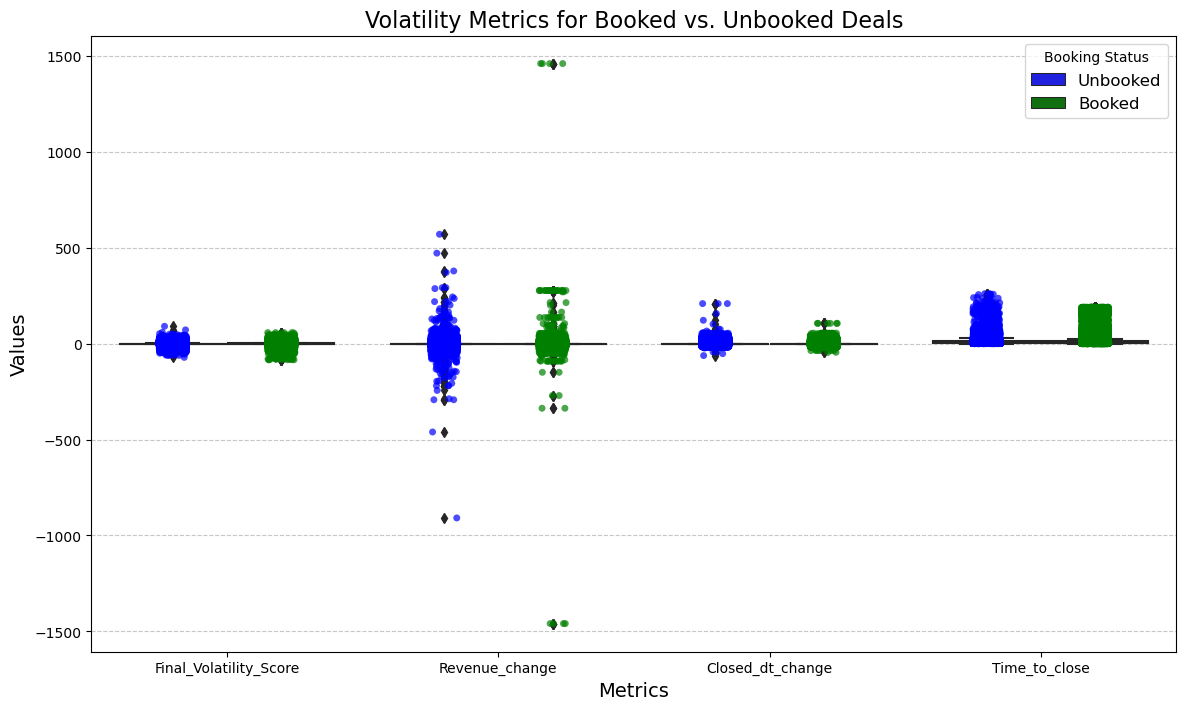

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the data for creating a grouped boxplot
metrics = ['Final_Volatility_Score', 'Revenue_change', 'Closed_dt_change', 'Time_to_close']
melted_df = fdf.melt(
    id_vars=['Is_Booked'], 
    value_vars=metrics, 
    var_name='Metric', 
    value_name='Value'
)

# Create the figure and boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(
    data=melted_df, 
    x='Metric', 
    y='Value', 
    hue='Is_Booked', 
    palette=['blue', 'green'],  # Blue for unbooked, green for booked
    dodge=True
)

# Overlay a stripplot for individual points with distinct shapes and colors
sns.stripplot(
    data=melted_df, 
    x='Metric', 
    y='Value', 
    hue='Is_Booked', 
    dodge=True, 
    palette=['blue', 'green'],  # Blue for unbooked, green for booked
    marker='o',  # 'o' for both, since hue differentiates color
    alpha=0.7, 
    edgecolor='black'
)

# Remove the second legend created by stripplot
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], ['Unbooked', 'Booked'], title='Booking Status', fontsize=12)

# Customize the plot
plt.title('Volatility Metrics for Booked vs. Unbooked Deals', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()


Z:\Python\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
Z:\Python\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
Z:\Python\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
Z:\Python\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
Z:\Python\Lib\site-packages\seaborn\

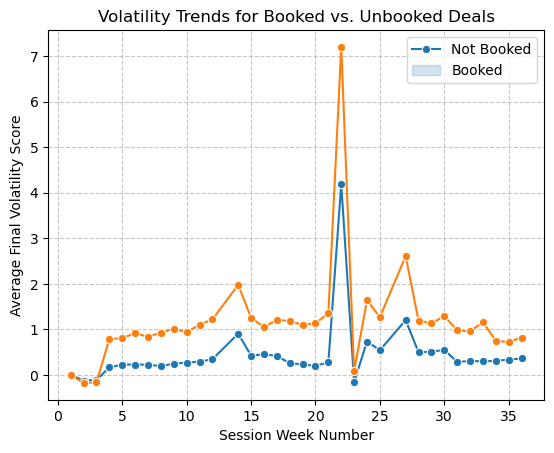

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by session week and booking status
trend_data = fdf.groupby(['Session_week_no', 'Is_Booked'])['Final_Volatility_Score'].mean().reset_index()

# Plot trends
sns.lineplot(data=trend_data, x='Session_week_no', y='Final_Volatility_Score', hue='Is_Booked', marker='o')
plt.title('Volatility Trends for Booked vs. Unbooked Deals')
plt.xlabel('Session Week Number')
plt.ylabel('Average Final Volatility Score')
plt.legend(['Not Booked', 'Booked'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# Prescriptive Analysis

In [45]:
# Flag high-priority deals for intervention
high_priority_deals = fdf[(fdf['Is_Booked'] == 0) & (fdf['Final_Volatility_Score'] > fdf['Final_Volatility_Score'].quantile(0.75))]

print("High-priority deals for intervention:")
print(high_priority_deals[['Deal_id', 'Final_Volatility_Score', 'Time_to_close', 'Revenue_change']])


High-priority deals for intervention:
          Deal_id  Final_Volatility_Score  Time_to_close  Revenue_change
42       A055068C                4.337947           18.0    7.839721e-01
43       A055068C                1.268418           17.0    0.000000e+00
44       A055068C                1.268418           16.0    0.000000e+00
45       A055068C                1.268418           15.0    1.592911e-09
64       A06B5077                3.829403           17.0    8.097578e-08
...           ...                     ...            ...             ...
1901627  BCCCC689                3.843379           16.0    0.000000e+00
1901628  BCCCC689                1.080046           15.0    0.000000e+00
1901629  BCCCC689                1.080046           14.0    0.000000e+00
1901630  BCCCC689                1.080046           13.0    0.000000e+00
1901632  BCCCC689                1.404867           19.0    0.000000e+00

[375050 rows x 4 columns]


Z:\Python\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
Z:\Python\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
Z:\Python\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
Z:\Python\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed

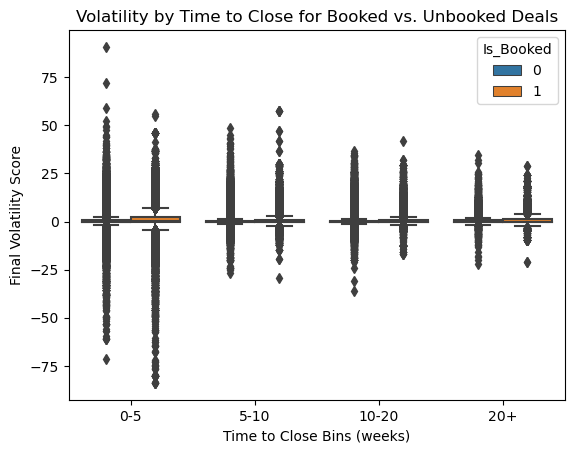

In [47]:
# Segment deals based on Time_to_close
fdf['Time_to_close_bin'] = pd.cut(fdf['Time_to_close'], bins=[0, 5, 10, 20, 50], labels=['0-5', '5-10', '10-20', '20+'])

# Plot Final Volatility Score by Time_to_close_bin
sns.boxplot(data=fdf, x='Time_to_close_bin', y='Final_Volatility_Score', hue='Is_Booked')
plt.title('Volatility by Time to Close for Booked vs. Unbooked Deals')
plt.xlabel('Time to Close Bins (weeks)')
plt.ylabel('Final Volatility Score')
plt.show()


# Predictive Analysis

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Define features and target
features = ['Final_Volatility_Score', 'Revenue_change', 'Time_to_close', 'Closed_dt_change']
target = 'Is_Booked'

X = fdf[features]
y = fdf[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classification model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


In [ ]:
from sklearn.cluster import KMeans

# Select features for clustering
clustering_features = ['Final_Volatility_Score', 'Revenue_change', 'Time_to_close']
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[clustering_features])

# Analyze clusters
sns.boxplot(data=fdf, x='Cluster', y='Final_Volatility_Score', hue='Is_Booked')
plt.title("Volatility Clusters for Booked vs. Unbooked Deals")
plt.show()
